In [6]:
#@title Install dependencies
!pip install git+https://github.com/huggingface/diffusers
!git clone https://github.com/huggingface/diffusers
!pip install -r diffusers/examples/dreambooth/requirements.txt
!pip install bitsandbytes
!pip install xformers
!pip install lit
!pip install colab-xterm

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-hxmg1_nh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-hxmg1_nh
  Resolved https://github.com/huggingface/diffusers to commit 869bad3e52c86a33452858901090dd86ff4bebe1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.27.0.dev0-py3-none-any.whl size=1947480 sha256=dbfc0b35699d6dc961a0995fc6b00c5dd3db2c5c0afb1ce656a2801bf81fa0ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-0fylhrbo/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers
Cloning into 'diffusers'...
remote: Enumerating objects: 56134, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 56134 (delta 126), reused 137 (delta 61), pack-reused 

In [7]:
#@title setup accelerate with floating point 16-bit
from accelerate.utils import write_basic_config
write_basic_config(mixed_precision="fp16")

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

## Log in to HuggingFace

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Mount Google Drive
For downloading person instance images and class images to workspace, and storing your model checkpoints output to google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Stable Diffusion

In [ ]:
#@title Try out stable diffusion model on HuggingFace

import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display

model_id = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)


In [ ]:
prompt = "A pikachu fine dining with a view to the Eiffel Tower" #@param {type:"string"}
image = pipe(prompt).images[0]

display(image)

## Use Microsoft/Promptist to refine prompt

In [ ]:
# Load Microsoft/Promptist pipeline
from transformers import pipeline

promptist_pipe = pipeline("text-generation", model="microsoft/Promptist")

In [ ]:
prompt = 'A pikachu fine dining with a view to the Eiffel Tower' #@param {type:"string"}
result = promptist_pipe('A pikachu fine dining with a view to the Eiffel Tower')
print(f'Optimized Prompt: {result[0]["generated_text"]}')

## **NOTE: Restart session to clear RAM for the latter execution.**

## DreamBooth Code setup
More details of the training script and parameters can be found in the following links: \\
https://github.com/huggingface/diffusers/tree/main/examples/dreambooth \\
https://huggingface.co/docs/diffusers/en/training/dreambooth

For guidance of selecting training and inference paramters, you find more information in this link: \\
https://huggingface.co/blog/dreambooth

In [ ]:
#@title Generate command for training model

#@markdown Pre-trained diffusion models from HuggingFace
model_name = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Directory containing your instance images
instance_dir = "/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/FrankDiffusion512" #@param {type:"string"}

#@markdown Directory containing your class images
class_dir = "/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/class_images" #@param {type:"string"}

#@markdown Directory for storing model output and checkpoints
output_dir = "/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/output_dir" #@param {type:"string"}

#@markdown Your instance prompt
instance_prompt = "a sks person" #@param {type:"string"}

#@markdown Your class prompt
class_prompt = "a person" #@param {type:"string"}

#@markdown Number of class images use in training
num_class_images = 1500 #@param {type:"integer"}

#@markdown Training steps use in training
max_training_steps = 500 #@param {type:"integer"}

#@markdown Checkpoint steps (frequency of saving checkpoints)
checkpointing_steps = 100 #@param {type:"integer"}

#@markdown Learning rate use in training
learning_rate = 0.000002 #@param {type:"number"}

#@markdown Resume to checkpoint
resume_checkpoint = False #@param {type:"boolean"}
checkpoint_number = 100 #@param {type:"number"}

# export directories for current process, needed for later use
!export MODEL_NAME=model_name
!export INSTANCE_DIR=instance_dir
!export CLASS_DIR=class_dir
!export OUTPUT_DIR=output_dir
!export INSTANCE_PROMPT=instance_prompt
!export CLASS_PROMPT=class_prompt

# create training command
training_command = f'''
export MODEL_NAME="{model_name}"
export INSTANCE_DIR="{instance_dir}"
export CLASS_DIR="{class_dir}"
export OUTPUT_DIR="{output_dir}"
export INSTANCE_PROMPT="{instance_prompt}"
export CLASS_PROMPT="{class_prompt}"
export NUM_CLASS_IMAGES={num_class_images}
export MAX_TRAIN_STEPS={max_training_steps}
export CHECKPOINTING_STEPS={checkpointing_steps}
export LEARNING_RATE={learning_rate}

accelerate launch --mixed_precision="fp16" "/content/diffusers/examples/dreambooth/train_dreambooth.py" \\
  --pretrained_model_name_or_path="$MODEL_NAME"  \\
  --train_text_encoder \\
  --instance_data_dir="$INSTANCE_DIR" \\
  --class_data_dir="$CLASS_DIR" \\
  --output_dir="$OUTPUT_DIR" \\
  --with_prior_preservation \\
  --prior_loss_weight=1.0 \\
  --instance_prompt="$INSTANCE_PROMPT" \\
  --class_prompt="$CLASS_PROMPT" \\
  --resolution=512 \\
  --train_batch_size=2 \\
  --gradient_accumulation_steps=2 \\
  --gradient_checkpointing \\
  --use_8bit_adam \\
  --learning_rate=$LEARNING_RATE \\
  --lr_scheduler="constant" \\
  --lr_warmup_steps=0 \\
  --num_class_images=$NUM_CLASS_IMAGES \\
  --max_train_steps=$MAX_TRAIN_STEPS \\
  --checkpointing_steps=$CHECKPOINTING_STEPS \\
  --enable_xformers_memory_efficient_attention \\
  --set_grads_to_none '''

if(resume_checkpoint):
  training_command += f'\\\n  --resume_from_checkpoint="{output_dir}/checkpoint-{checkpoint_number}"'

print(training_command)


export MODEL_NAME="CompVis/stable-diffusion-v1-4"
export INSTANCE_DIR="/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/FrankDiffusion512"
export CLASS_DIR="/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/class_images"
export OUTPUT_DIR="/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/output_dir"
export INSTANCE_PROMPT="a sks person"
export CLASS_PROMPT="a person"
export NUM_CLASS_IMAGES=1500
export MAX_TRAIN_STEPS=500
export CHECKPOINTING_STEPS=100
export LEARNING_RATE=2e-06

accelerate launch --mixed_precision="fp16" "/content/diffusers/examples/dreambooth/train_dreambooth.py" \
  --pretrained_model_name_or_path="$MODEL_NAME"  \
  --train_text_encoder \
  --instance_data_dir="$INSTANCE_DIR" \
  --class_data_dir="$CLASS_DIR" \
  --output_dir="$OUTPUT_DIR" \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --instance_prompt="$INSTANCE_PROMPT" \
  --class_prompt="$CLASS_PROMPT" \
  --resolu

## Copy-Past-and-Run the above code in this xterm window

In [ ]:
%load_ext colabxterm
%xterm

Run this block of code during training to avoid Google Colab from timing out. \
NOTE! If you killed this cell, it will also kill the xterm process in the above cell. (Only kill this cell if your training is complete.)

In [ ]:
#@title Run this code to prevent runtime timeout
from time import sleep
from datetime import datetime
while 1:
  print('Preventing runtime timeout... Current time:', datetime.now())
  sleep(60)

Preventing runtime timeout... Current time: 2024-03-04 08:48:53.027216
Preventing runtime timeout... Current time: 2024-03-04 08:49:53.083074
Preventing runtime timeout... Current time: 2024-03-04 08:50:53.143396
Preventing runtime timeout... Current time: 2024-03-04 08:51:53.204614
Preventing runtime timeout... Current time: 2024-03-04 08:52:53.243048
Preventing runtime timeout... Current time: 2024-03-04 08:53:53.274082
Preventing runtime timeout... Current time: 2024-03-04 08:54:53.307047


KeyboardInterrupt: 

## Try out your
Test out your model by giving it various prompt. (e.g. "a sks person with blue hair", "a sks person wearing chef outfit") \
If your model is not affected by your prompt, then most likely, your model has overfitted to the training images. In this case, try out an earlier checkpoint.

Load model with this cell

In [9]:
#@title Load the model currently at the root of the output directory

#@markdown scheduler for sampling images during inference (see https://huggingface.co/blog/dreambooth#effect-of-schedulers)
scheduler_name = "DDIM" #@param ["DDIM", "DPMSolverMultistep"]

#@markdown Resume to checkpoint
output_dir = "/content/drive/MyDrive/school/ECE157B/HW3/ECE157B_272B_Winter_2024_Homework3/output_dir" #@param {type:"string"}
checkpoint_number = 500 #@param {type:"number"}

from diffusers import (
    StableDiffusionPipeline,
    DPMSolverMultistepScheduler,
    DDIMScheduler
)
import torch

checkpoint_dir = f'{output_dir}/checkpoint-{checkpoint_number}'

schedulers = {
    'DPMSolverMultistep': DPMSolverMultistepScheduler.from_pretrained,
    'DDIM': DDIMScheduler.from_pretrained
}

scheduler = schedulers[scheduler_name]

pipe = StableDiffusionPipeline.from_pretrained(output_dir,
          scheduler=scheduler(output_dir, subfolder="scheduler"),
          torch_dtype=torch.float16
        ).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

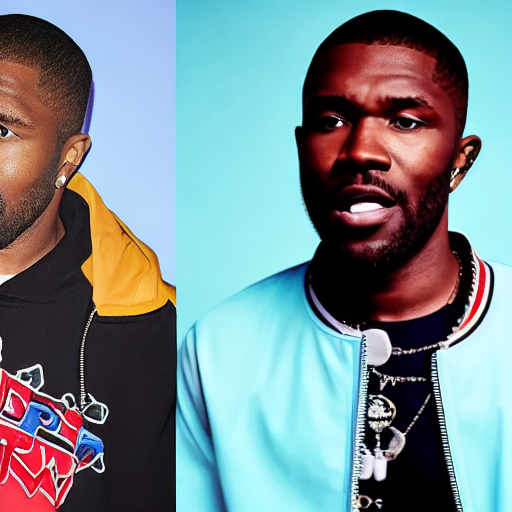

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


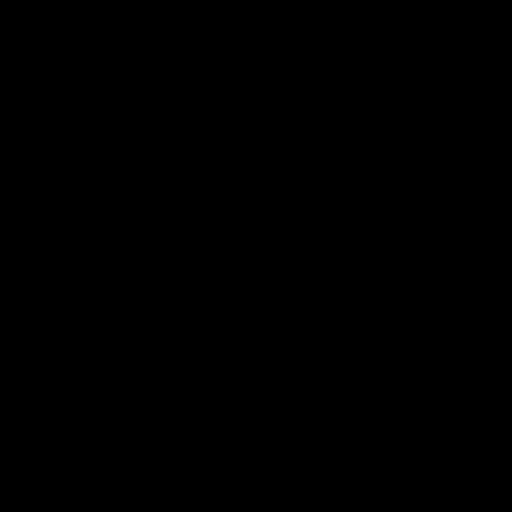

  0%|          | 0/50 [00:00<?, ?it/s]

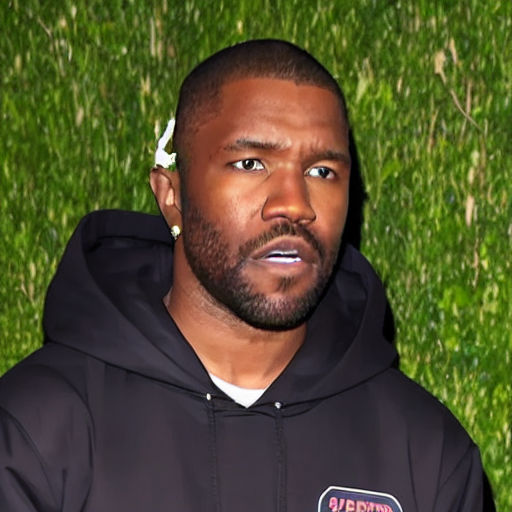

In [15]:
#@title Generate image from prompt

#@markdown Prompt use to generate images
prompt = "a sks person singing" #@param {type:"string"}

#@markdown Number of inference steps
num_inference_steps = 50 #@param {type:"integer"}

#@markdown Guidance scale
guidance_scale = 7.5 #@param {type:"number"}

#@markdown Number of image to generate
num_images = 3 #@param {type:"integer"}

from IPython.display import display
for _ in range(num_images):
  image = pipe(prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale
               ).images[0]
  display(image)

In [ ]:
#@title Save your fine-tuned model to your huggingface-hub (Code from [HuggingFace Stable Diffusion Dreambooth Concepts Library](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb) with modifications)

#@markdown HuggingFace repository name where the model will be saved to
repo_name = "frankieModel" #@param {type:"string"}

import os
from slugify import slugify
from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
from huggingface_hub import create_repo
from IPython.display import display_markdown

# some api and huggingface account setup
api = HfApi()
your_username = api.whoami()["name"]

# save the model in the root of the model output folder
os.makedirs("fp16_model",exist_ok=True)
pipe.save_pretrained("fp16_model")

# retrieve your huggingFace repo and upload model
repo_id = f"{your_username}/{slugify(repo_name)}"


with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();


readme_text = f'''---
license: creativeml-openrail-m
tags:
- text-to-image
---
### Fine-tuned Stable Diffusion via Dreambooth
#### model by {api.whoami()["name"]}
A fine-tuned Stable Diffusion via Dreambooth
'''

# Save the readme to a file
readme_file = open("README.md", "w")
readme_file.write(readme_text)
readme_file.close()

# Save the token identifier to a file
text_file = open("token_identifier.txt", "w")
text_file.close()
operations = [
  CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
  CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
]

# create private repo
create_repo(repo_id, private=True, token=hf_token)

# commit and upload model
api.create_commit(
  repo_id=repo_id,
  operations=operations,
  commit_message=f"Uploaded fine-tuned model.",
  token=hf_token
)
api.upload_folder(
  folder_path="fp16_model",
  path_in_repo="",
  repo_id=repo_id,
  token=hf_token
)


print(f'## Your model was saved successfully. [Click here to access it](https://huggingface.co/{repo_id})')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

## Your model was saved successfully. [Click here to access it](https://huggingface.co/ethan3048/frankiemodel)


In [ ]:
#@title DELETE checkpoint to free up space

#@markdown Checkpoint to be deleted
delete_confirmation = False #@param {type:"boolean"}
checkpoint_number = None #@param {type:"number"}

import shutil

if(delete_confirmation):
  shutil.rmtree(f'{output_dir}/checkpoint-{checkpoint_number}')
